In [122]:
from env import get_db_url
import pandas as pd
import numpy as np
import os
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

In [3]:
def get_store_data(use_cache = True):
    """
    Get store data from the database.
    """
    filename = "store_data.csv"
    if os.path.isfile(filename) and use_cache:
        print("Loading store data from cache...")
        store_data = pd.read_csv(filename)
    print("reading store data from database...")
    url = get_db_url('superstore_db')
    query = '''
    SELECT  orders.*,
        categories.`Category`, 
        categories.`Sub-Category`,
        customers.`Customer Name`,
        products.`Product Name`,
        regions.`Region Name`
    FROM orders
    LEFT JOIN categories USING (`Category ID`)
    LEFT JOIN customers USING (`Customer ID`)
    LEFT JOIN products USING (`Product ID`)
    LEFT JOIN regions USING (`Region ID`)
    '''
    df = pd.read_sql(query, url)
    print("writing store data to cache...")
    df.to_csv(filename, index = False)
    return df

In [4]:
df = get_store_data(use_cache=False)
df.head()

reading store data from database...
writing store data to cache...


,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Segment,Country,City,State,Postal Code,...,Quantity,Discount,Profit,Category ID,Region ID,Category,Sub-Category,Customer Name,Product Name,Region Name
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,42420.0,...,2.0,0.00,41.9136,1,1,Furniture,Bookcases,Claire Gute,Bush Somerset Collection Bookcase,South
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,42420.0,...,3.0,0.00,219.5820,2,1,Furniture,Chairs,Claire Gute,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",South
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,United States,Los Angeles,California,90036.0,...,2.0,0.00,6.8714,3,2,Office Supplies,Labels,Darrin Van Huff,Self-Adhesive Address Labels for Typewriters b...,West
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,33311.0,...,5.0,0.45,-383.0310,4,1,Furniture,Tables,Sean O'Donnell,Bretford CR4500 Series Slim Rectangular Table,South
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,33311.0,...,2.0,0.20,2.5164,5,1,Office Supplies,Storage,Sean O'Donnell,Eldon Fold 'N Roll Cart System,South


In [150]:
df.shape

(1734, 24)

In [5]:
# rename all columns to lowercase
df.columns = [c.lower() for c in df.columns]
# replace spaces in column names with underscores
df.columns = [c.replace(' ', '_') for c in df.columns]
# replace - with _ in column names
df.columns = [c.replace('-', '_') for c in df.columns]
# convert the date columns to datetime
df['order_date'] = pd.to_datetime(df['order_date'])
df['ship_date'] = pd.to_datetime(df['ship_date'])


In [6]:
df.isnull().sum()
#no null values

order_id         0
order_date       0
ship_date        0
ship_mode        0
customer_id      0
segment          0
country          0
city             0
state            0
postal_code      0
product_id       0
sales            0
quantity         0
discount         0
profit           0
category_id      0
region_id        0
category         0
sub_category     0
customer_name    0
product_name     0
region_name      0
dtype: int64

In [7]:
df.sales.min(), df.sales.max()

(1.0799999999999998, 8159.951999999998)

In [60]:
# create a new df for items, quantity, and price, discount
df_items = df[['order_id', 'product_id', 'quantity', 'discount', 'sales', 'profit', 'order_date']].copy()
#add unit cost column
df_items['unit_cost'] = df_items.sales / ((1-df_items.discount) * df_items.quantity)
#add unit profit column
df_items['unit_profit'] = df_items.profit / df_items.quantity
df_items.head()




,order_id,product_id,quantity,discount,sales,profit,order_date,unit_cost,unit_profit
0,CA-2016-152156,FUR-BO-10001798,2.0,0.00,261.9600,41.9136,2016-11-08,130.98,20.9568
1,CA-2016-152156,FUR-CH-10000454,3.0,0.00,731.9400,219.5820,2016-11-08,243.98,73.1940
2,CA-2016-138688,OFF-LA-10000240,2.0,0.00,14.6200,6.8714,2016-06-12,7.31,3.4357
3,US-2015-108966,FUR-TA-10000577,5.0,0.45,957.5775,-383.0310,2015-10-11,348.21,-76.6062
4,US-2015-108966,OFF-ST-10000760,2.0,0.20,22.3680,2.5164,2015-10-11,13.98,1.2582


In [55]:
# which items are most commonly sold?
df_items.groupby('product_id').quantity.sum().sort_values(ascending=False).head(10)

product_id
TEC-AC-10003832    29.0
OFF-PA-10001970    26.0
OFF-AR-10004042    24.0
FUR-TA-10002607    24.0
OFF-ST-10000604    23.0
OFF-AR-10003373    22.0
OFF-PA-10004530    22.0
OFF-AR-10003514    22.0
FUR-FU-10001706    22.0
FUR-FU-10000010    22.0
Name: quantity, dtype: float64

In [61]:
# look where product id  is TEC-AC-10003832
df_items[df_items.product_id == 'TEC-AC-10003832']

,order_id,product_id,quantity,discount,sales,profit,order_date,unit_cost,unit_profit
235,US-2017-100930,TEC-AC-10003832,3.0,0.2,617.976,-7.7247,2017-04-07,257.49,-2.5749
251,CA-2016-145625,TEC-AC-10003832,13.0,0.0,3347.370,636.0003,2016-09-11,257.49,48.9231
524,US-2016-139486,TEC-AC-10003832,2.0,0.0,66.260,27.1666,2016-05-21,33.13,13.5833
643,CA-2017-106103,TEC-AC-10003832,4.0,0.0,132.520,54.3332,2017-06-10,33.13,13.5833
675,CA-2017-130351,TEC-AC-10003832,3.0,0.0,99.390,40.7499,2017-12-05,33.13,13.5833
1653,US-2017-132444,TEC-AC-10003832,4.0,0.0,132.520,54.3332,2017-11-18,33.13,13.5833


In [62]:
# look where product_id is OFF-PA-10001970
df_items[df_items.product_id == 'OFF-PA-10001970']

,order_id,product_id,quantity,discount,sales,profit,order_date,unit_cost,unit_profit
350,CA-2016-129714,OFF-PA-10001970,2.0,0.0,24.560,11.5432,2016-09-01,12.28,5.7716
352,CA-2016-129714,OFF-PA-10001970,4.0,0.0,49.120,23.0864,2016-09-01,12.28,5.7716
411,CA-2017-117457,OFF-PA-10001970,1.0,0.0,55.980,27.4302,2017-12-08,55.98,27.4302
437,CA-2016-147375,OFF-PA-10001970,7.0,0.2,313.488,113.6394,2016-06-12,55.98,16.2342
1071,CA-2016-152814,OFF-PA-10001970,3.0,0.2,29.472,9.9468,2016-04-28,12.28,3.3156
1117,CA-2015-142755,OFF-PA-10001970,5.0,0.0,279.900,137.1510,2015-09-04,55.98,27.4302
1191,CA-2017-117212,OFF-PA-10001970,4.0,0.0,223.920,109.7208,2017-02-26,55.98,27.4302


In [9]:
df_items.describe()

,quantity,discount,sales,profit,unit_cost,unit_profit
count,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000,1734.000000
mean,3.794694,0.160110,229.206358,21.880351,74.890006,6.197098
std,2.297407,0.206419,532.862614,202.891949,175.232540,49.454376
min,1.000000,0.000000,1.080000,-3839.990400,1.240000,-959.997600
25%,2.000000,0.000000,16.695000,1.702400,6.480000,0.722800
50%,3.000000,0.200000,52.245000,8.073050,19.990000,2.660250
75%,5.000000,0.200000,209.917500,27.414450,79.872500,8.158600
max,14.000000,0.800000,8159.952000,3177.475000,3999.990000,997.995000


In [10]:
df[['product_id', 'product_name']].sort_values('product_name')

,product_id,product_name
1708,OFF-PA-10003424,"""While you Were Out"" Message Book, One Form pe..."
355,OFF-EN-10001137,"#10 Gummed Flap White Envelopes, 100/Box"
985,OFF-EN-10000461,"#10- 4 1/8"" x 9 1/2"" Recycled Envelopes"
1228,OFF-EN-10001219,"#10- 4 1/8"" x 9 1/2"" Security-Tint Envelopes"
711,OFF-EN-10001219,"#10- 4 1/8"" x 9 1/2"" Security-Tint Envelopes"
...,...,...
1679,TEC-PH-10003589,invisibleSHIELD by ZAGG Smudge-Free Screen Pro...
1612,TEC-PH-10002726,netTALK DUO VoIP Telephone Service
1696,TEC-PH-10002726,netTALK DUO VoIP Telephone Service
1672,TEC-PH-10002726,netTALK DUO VoIP Telephone Service


In [11]:
df.discount.value_counts()

0.00    810
0.20    656
0.70     82
0.80     46
0.40     41
0.30     31
0.60     19
0.50     18
0.10     14
0.15      8
0.45      5
0.32      4
Name: discount, dtype: int64

In [50]:
# add a column for brand
df['brand'] = df.product_name.str.split(' ').str[0]
df.head()


,order_id,order_date,ship_date,ship_mode,customer_id,segment,country,city,state,postal_code,...,discount,profit,category_id,region_id,category,sub_category,customer_name,product_name,region_name,brand
0,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,42420.0,...,0.00,41.9136,1,1,Furniture,Bookcases,Claire Gute,Bush Somerset Collection Bookcase,South,Bush
1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Consumer,United States,Henderson,Kentucky,42420.0,...,0.00,219.5820,2,1,Furniture,Chairs,Claire Gute,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",South,Hon
2,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Corporate,United States,Los Angeles,California,90036.0,...,0.00,6.8714,3,2,Office Supplies,Labels,Darrin Van Huff,Self-Adhesive Address Labels for Typewriters b...,West,Self-Adhesive
3,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,33311.0,...,0.45,-383.0310,4,1,Furniture,Tables,Sean O'Donnell,Bretford CR4500 Series Slim Rectangular Table,South,Bretford
4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Consumer,United States,Fort Lauderdale,Florida,33311.0,...,0.20,2.5164,5,1,Office Supplies,Storage,Sean O'Donnell,Eldon Fold 'N Roll Cart System,South,Eldon


In [13]:
df.brand.value_counts()

Xerox              133
Avery               95
GBC                 54
Newell              45
Eldon               43
                  ... 
Companion            1
Fluorescent          1
Magnifier            1
Logitech Gaming      1
Avanti               1
Name: brand, Length: 371, dtype: int64

In [14]:
# # round sales and profit to 2 decimal places
# df['sales'] = df.sales.round(2)
# df['profit'] = df.profit.round(2)


In [15]:
# how many brands have more than 1 product
df.brand.value_counts()[df.brand.value_counts() > 10]

Xerox          133
Avery           95
GBC             54
Newell          45
Eldon           43
Global          43
Fellowes        42
Acco            34
Wilson          33
Logitech        31
Hon             27
Belkin          26
Howard          17
Boston          15
Cisco           15
Safco           14
Ibico           14
Acme            14
Tenex           13
Advantus        13
Bush            13
Staples         12
Bevis           12
Staple          12
Recycled        12
Plantronics     11
Kensington      11
DAX             11
Panasonic       11
Cardinal        11
Name: brand, dtype: int64

<AxesSubplot:xlabel='brand'>

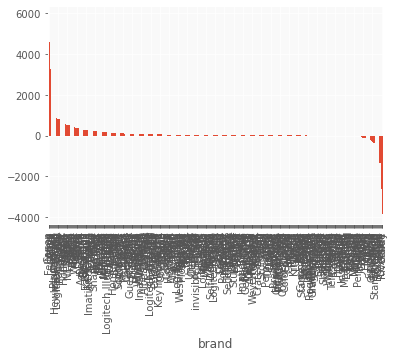

In [18]:
# graph brand vs profit
df.groupby('brand').profit.sum().sort_values(ascending=False).plot(kind='bar')

In [31]:
# most common brands
common_brands = df.brand.value_counts()[df.brand.value_counts() > 10].index.tolist()

<AxesSubplot:xlabel='brand'>

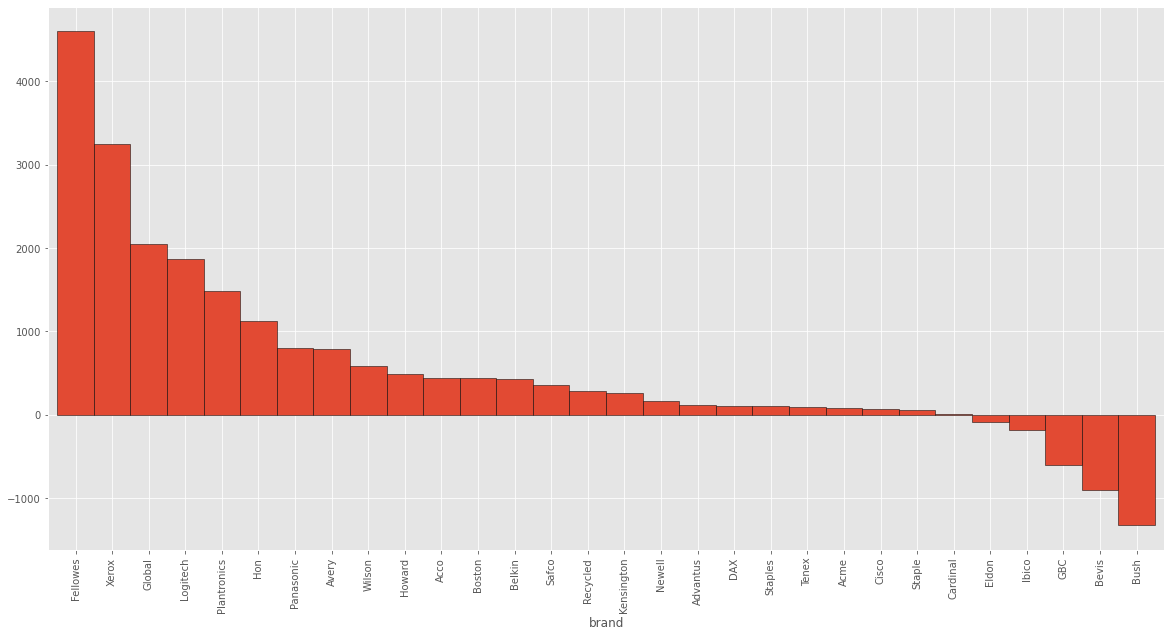

In [42]:
# make a new df wiht only the common brands
df_common_brands = df[df.brand.isin(common_brands)]
# change figure size
plt.figure(figsize=(20,10))
#graph brand vs profit
df_common_brands.groupby('brand').profit.sum().sort_values(ascending=False).plot(kind='bar', width = 1.0, ec='black')



In [65]:
# how many categories per brand
df_common_brands.groupby('brand').category.nunique().sort_values(ascending=False).head(10)

brand
Xerox         2
Advantus      2
Wilson        2
Belkin        2
Tenex         2
Safco         2
Eldon         2
Panasonic     2
Kensington    2
Ibico         1
Name: category, dtype: int64

In [69]:
# brand Xerox has which categories
df_common_brands[df_common_brands.brand == 'Xerox'].sub_category.unique()

array(['Paper', 'Machines'], dtype=object)

In [75]:
df_common_brands[df_common_brands.brand == 'Xerox'].product_name.value_counts()

Xerox 1881    7
Xerox 1916    4
Xerox 196     3
Xerox 1943    3
Xerox 1995    3
             ..
Xerox 1931    1
Xerox 1985    1
Xerox 213     1
Xerox 1920    1
Xerox 1925    1
Name: product_name, Length: 88, dtype: int64

In [78]:
# make a new column in df for product_line
df['product_line'] = df.brand + '_' + df.sub_category

In [81]:
# how many unique item_name per product_line
df.groupby('product_line').product_name.nunique().sort_values(ascending=False).head(10)


product_line
Xerox_Paper             87
Newell_Art              37
Avery_Labels            35
GBC_Binders             30
Avery_Binders           24
Global_Chairs           24
Eldon_Furnishings       19
Wilson_Binders          18
Logitech_Accessories    17
Acco_Binders            14
Name: product_name, dtype: int64

In [83]:
# profit per product_line
df.groupby('product_line').profit.mean().sort_values(ascending=False).head(10)



product_line
Ativa_Machines              2400.965700
Hewlett-Packard_Machines    1459.200000
Canon_Machines              1019.594550
Maxell iVDR_Accessories      829.375400
Canon_Copiers                761.485780
Fellowes_Binders             464.570211
Sharp_Copiers                434.991300
Bose_Phones                  376.110000
Hewlett_Copiers              355.493450
Honeywell_Appliances         337.486750
Name: profit, dtype: float64

In [85]:
# profit per product_line
df.groupby('product_line').profit.sum().sort_values(ascending=False).head(10)

product_line
Fellowes_Binders            4181.1319
Canon_Copiers               3807.4289
Xerox_Paper                 3495.3466
Ativa_Machines              2400.9657
Global_Chairs               2047.7446
Canon_Machines              2039.1891
Logitech_Accessories        1787.3056
Hewlett-Packard_Machines    1459.2000
Hon_Chairs                  1264.4557
Plantronics_Accessories     1193.1090
Name: profit, dtype: float64

In [84]:
# profit per product_line
df.groupby('product_line').profit.mean().sort_values(ascending=True).head(10)

product_line
Cubify_Machines         -3839.99040
Riverside_Bookcases      -991.10250
Riverside_Tables         -619.59600
StarTech.com_Machines    -559.35600
Swingline_Machines       -383.99040
BoxOffice_Tables         -364.21875
Bush_Tables              -336.99230
Office_Tables            -297.68480
Lexmark_Machines         -267.51020
Xerox_Machines           -251.99580
Name: profit, dtype: float64

### questions
Is there a product category that is particularly profitable for us? 

In [86]:
# show profit by category
df.groupby('category').profit.sum().sort_values(ascending=False).head(10)

category
Office Supplies    19312.4297
Technology         19251.3447
Furniture           -623.2451
Name: profit, dtype: float64

In [88]:
# show profit by category
df.groupby('category').profit.mean().sort_values(ascending=False).head(10)

category
Technology         60.349043
Office Supplies    18.305621
Furniture          -1.731236
Name: profit, dtype: float64

Does one or another stand out in terms of sales volume?

In [89]:
# show quantity by category
df.groupby('category').quantity.sum().sort_values(ascending=False).head(10)

category
Office Supplies    3974.0
Furniture          1401.0
Technology         1205.0
Name: quantity, dtype: float64

Does this vary by customer segment?

In [92]:
df.segment.value_counts()

Consumer       954
Corporate      478
Home Office    302
Name: segment, dtype: int64

In [128]:
df.segment.value_counts()/df.segment.value_counts().sum()

Consumer       0.550173
Corporate      0.275663
Home Office    0.174164
Name: segment, dtype: float64

In [93]:
# split df consumer, corporate, and home_office
df_consumer = df[df.segment == 'Consumer']
df_corporate = df[df.segment == 'Corporate']
df_home_office = df[df.segment == 'Home Office']




In [94]:
# show profit by category
df_consumer.groupby('category').profit.sum().sort_values(ascending=False).head(10)

category
Technology         13628.3838
Office Supplies     9561.4123
Furniture          -2516.3903
Name: profit, dtype: float64

In [95]:
df_corporate.groupby('category').profit.sum().sort_values(ascending=False).head(10)

category
Office Supplies    5806.4740
Furniture          1849.1334
Technology         -774.9598
Name: profit, dtype: float64

In [96]:
df_home_office.groupby('category').profit.sum().sort_values(ascending=False).head(10)

category
Technology         6397.9207
Office Supplies    3944.5434
Furniture            44.0118
Name: profit, dtype: float64

In [97]:
df_consumer.groupby('category').quantity.sum().sort_values(ascending=False).head(10)

category
Office Supplies    2127.0
Furniture           782.0
Technology          659.0
Name: quantity, dtype: float64

In [98]:
df_corporate.groupby('category').quantity.sum().sort_values(ascending=False).head(10)

category
Office Supplies    1183.0
Furniture           357.0
Technology          332.0
Name: quantity, dtype: float64

In [99]:
df_home_office.groupby('category').quantity.sum().sort_values(ascending=False).head(10)

category
Office Supplies    664.0
Furniture          262.0
Technology         214.0
Name: quantity, dtype: float64

In [110]:
#combine above into a single df
segment_quantity_df = pd.DataFrame()
segment_quantity_df['consumer_quantity'] = df_consumer.groupby('category').quantity.sum().sort_values(ascending=False).head(10)
segment_quantity_df['corporate_quantity'] = df_corporate.groupby('category').quantity.sum().sort_values(ascending=False).head(10)
segment_quantity_df['home_office_quantity'] = df_home_office.groupby('category').quantity.sum().sort_values(ascending=False).head(10)
segment_quantity_df


,consumer_quantity,corporate_quantity,home_office_quantity
category,,,
Office Supplies,2127.0,1183.0,664.0
Furniture,782.0,357.0,262.0
Technology,659.0,332.0,214.0


In [151]:
#combine above into a single df
segment_profit_df = pd.DataFrame()
segment_profit_df['consumer_profit'] = df_consumer.groupby('category').profit.sum().sort_values(ascending=False).head(10)
segment_profit_df['corporate_profit'] = df_corporate.groupby('category').profit.sum().sort_values(ascending=False).head(10)
segment_profit_df['home_office_profit'] = df_home_office.groupby('category').profit.sum().sort_values(ascending=False).head(10)
# add a row for total
segment_profit_df.loc['total'] = segment_profit_df.sum()
# get total profit
total_profit = df.groupby('sub_category').sum()['profit'].sort_values(ascending=False).sum()
segment_profit_df.loc['percent'] = segment_profit_df.loc['total']/total_profit

segment_profit_df

,consumer_profit,corporate_profit,home_office_profit
category,,,
Technology,13628.38380,-774.959800,6397.920700
Office Supplies,9561.41230,5806.474000,3944.543400
Furniture,-2516.39030,1849.133400,44.011800
total,20673.40580,6880.647600,10386.475900
percent,0.54489,0.181353,0.273757


<AxesSubplot:xlabel='category'>

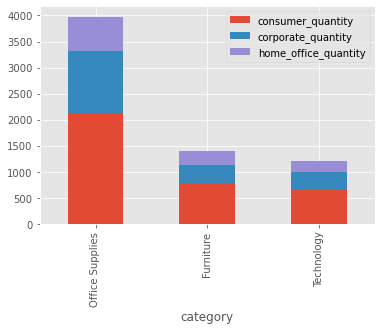

In [146]:
# graph quantity by category
segment_quantity_df.plot(kind='bar', stacked=True)

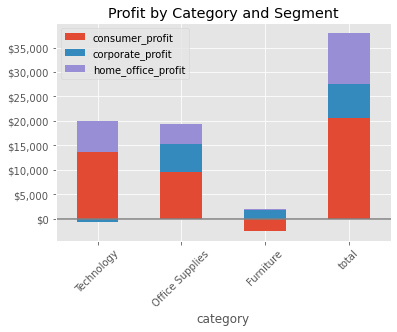

In [149]:
import matplotlib.pyplot as plt
segment_profit_df.plot(kind='bar', stacked=True,)
# change x axis rotation
plt.xticks(rotation=45)
#add title
plt.title('Profit by Category and Segment')
# ser y ticks to be in dollars
# add line at 0
plt.axhline(y=0, color='grey')
ax = plt.gca()
ax.yaxis.set_major_formatter('${x:,.0f}')


<AxesSubplot:xlabel='order_date'>

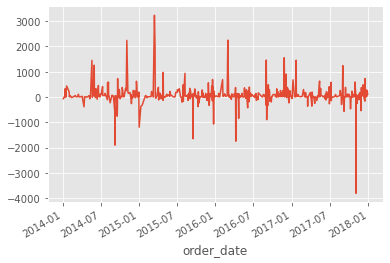

In [115]:
# chart profit over time
df.groupby('order_date').profit.sum().plot(kind='line')

<AxesSubplot:xlabel='order_date', ylabel='profit'>

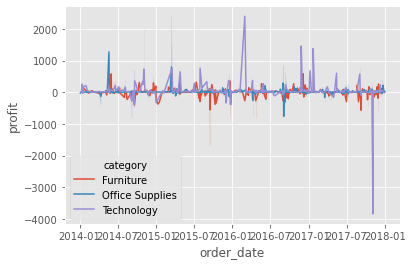

In [119]:
# chart profit by category over time using seaborn
sns.lineplot(x='order_date', y='profit', data=df, hue='category')


In [125]:
df.sub_category.value_counts()

Binders        263
Paper          224
Furnishings    168
Storage        162
Phones         157
Art            149
Accessories    131
Chairs          95
Appliances      71
Labels          67
Tables          62
Envelopes       48
Fasteners       43
Bookcases       35
Supplies        28
Machines        21
Copiers         10
Name: sub_category, dtype: int64